# Commodity Price Prediction - Complete Demo

Pipeline:
1. **Load & Validate** data
2. **Clean & Preprocess** (auto-detect frequency)
3. **Feature Engineering** (44 features)
4. **Train/Test Split** (chronological 80/20)
5. **Model Training** (Baseline + 6 ML models)
6. **Evaluation & Comparison**
7. **Future Price Forecast** (N-day ahead)

In [53]:
# === Setup ===
import warnings
warnings.filterwarnings('ignore')

import os, sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

PROJECT_ROOT = os.path.dirname(os.path.abspath('__file__'))
if PROJECT_ROOT not in sys.path:
    sys.path.insert(0, PROJECT_ROOT)

print(f'Project root: {PROJECT_ROOT}')
print(f'Python: {sys.version}')

Project root: d:\Work\Comodity-Price-Forecasting
Python: 3.12.7 | packaged by Anaconda, Inc. | (main, Oct  4 2024, 13:17:27) [MSC v.1929 64 bit (AMD64)]


## 1. Load & Validate Data

In [54]:
from src.ingestion.loader import CommodityLoader
from src.ingestion.validator import DataValidator

loader = CommodityLoader()
validator = DataValidator()

commodities = loader.list_commodities()
print(f'Available commodities ({len(commodities)}):')
for c in commodities:
    print(f"  - {c['id']:12s}  {c['name']}")

Available commodities (14):
  - crude_oil     Crude Oil (WTI)
  - coffee        Coffee Arabica
  - corn          Corn
  - cotton        Cotton
  - gas           Gas
  - milk          Milk
  - oil           Oil
  - pork          Pork
  - pvc           Pvc
  - rubber        Rubber
  - rice          Rice
  - steel         Steel
  - sugar         Sugar
  - urea          Urea


In [55]:
# Load all commodities summary
summary_rows = []
for c in commodities:
    try:
        df = loader.load_commodity(c['id'])
        report = validator.validate(df, c['id'])
        summary_rows.append({
            'commodity': c['id'], 'name': c['name'], 'rows': len(df),
            'start': str(df['date'].min().date()), 'end': str(df['date'].max().date()),
            'valid': report.passed,
        })
    except Exception as e:
        summary_rows.append({'commodity': c['id'], 'name': c['name'], 'rows': 0, 'valid': False})

pd.DataFrame(summary_rows)

2026-02-10 11:41:14.721 | INFO     | src.ingestion.loader:load_commodity:80 - Loaded 261 records for crude_oil
2026-02-10 11:41:14.734 | INFO     | src.ingestion.loader:load_commodity:80 - Loaded 2556 records for coffee
2026-02-10 11:41:15.013 | INFO     | src.ingestion.loader:load_commodity:80 - Loaded 2542 records for corn
2026-02-10 11:41:15.061 | INFO     | src.ingestion.loader:load_commodity:80 - Loaded 2598 records for cotton
2026-02-10 11:41:15.115 | INFO     | src.ingestion.loader:load_commodity:80 - Loaded 2544 records for gas
2026-02-10 11:41:15.164 | INFO     | src.ingestion.loader:load_commodity:80 - Loaded 2555 records for milk
2026-02-10 11:41:15.220 | INFO     | src.ingestion.loader:load_commodity:80 - Loaded 2616 records for oil
2026-02-10 11:41:15.272 | INFO     | src.ingestion.loader:load_commodity:80 - Loaded 3015 records for pork
2026-02-10 11:41:15.316 | INFO     | src.ingestion.loader:load_commodity:80 - Loaded 352 records for pvc
2026-02-10 11:41:15.327 | INFO   

,commodity,name,rows,start,end,valid
0,crude_oil,Crude Oil (WTI),261,2024-01-02,2024-12-31,True
1,coffee,Coffee Arabica,2556,2016-01-04,2026-02-03,True
2,corn,Corn,2542,2016-01-04,2026-02-03,True
3,cotton,Cotton,2598,2016-01-04,2026-02-03,True
4,gas,Gas,2544,2016-01-04,2026-02-03,True
5,milk,Milk,2555,2016-01-04,2026-02-03,True
6,oil,Oil,2616,2016-01-04,2026-02-03,True
7,pork,Pork,3015,2016-01-04,2025-12-31,False
8,pvc,Pvc,352,2024-11-22,2026-01-16,True
9,rubber,Rubber,1489,2020-01-03,2026-02-05,True


In [56]:
# ===== CHOOSE COMMODITY =====
COMMODITY_ID = 'rubber'  # <-- Change this to any commodity
# ============================

df_raw = loader.load_commodity(COMMODITY_ID)
print(f'Loaded {COMMODITY_ID}: {len(df_raw)} rows')
print(f'Date range: {df_raw["date"].min().date()} to {df_raw["date"].max().date()}')
df_raw.head()

2026-02-10 11:41:25.539 | INFO     | src.ingestion.loader:load_commodity:80 - Loaded 1489 records for rubber


Loaded rubber: 1489 rows
Date range: 2020-01-03 to 2026-02-05


,date,close,commodity_id
0,2020-01-03,202.4,rubber
1,2020-01-06,201.3,rubber
2,2020-01-07,202.6,rubber
3,2020-01-08,201.0,rubber
4,2020-01-09,201.4,rubber


In [57]:
report = validator.validate(df_raw, COMMODITY_ID)
print(report.summary())

Validation Report for rubber
Status: ✅ PASSED
Errors: 0, Warnings: 0
--------------------------------------------------
✅ required_columns: All required columns present
✅ date_parseable: All dates are parseable
✅ date_unique: All dates are unique
✅ date_chronological: Dates are in chronological order
✅ close_numeric: Close values are numeric
✅ close_positive: All close values are non-negative
✅ close_not_null: No null close values
✅ missing_dates: 101 missing dates (6.4%)
✅ outliers: No significant outliers detected
✅ min_history: 1489 records (>= 200)


## 2. Clean & Preprocess

In [58]:
from src.preprocessing.cleaner import DataCleaner
from src.preprocessing.transformer import TargetTransformer

cleaner = DataCleaner(frequency='auto', fill_method='ffill', max_gap_days=10)
df_clean = cleaner.clean(df_raw)

quality = cleaner.get_quality_summary(df_clean)
print(f'Cleaned: {quality["total_rows"]} rows')
print(f'Original: {quality["original_rows"]} ({quality["original_pct"]:.1%})')
print(f'Imputed:  {quality["imputed_rows"]} ({quality["imputed_pct"]:.1%})')
print(f'Missing:  {quality["missing_rows"]}, Outliers: {quality["outlier_rows"]}')

transformer = TargetTransformer(method='none')
df_transformed = transformer.transform(df_clean)
df_clean.head()

2026-02-10 11:41:38.310 | INFO     | src.preprocessing.cleaner:_detect_frequency:114 - Auto-detected business frequency (0.0% weekend dates)


Cleaned: 1590 rows
Original: 1489 (93.6%)
Imputed:  101 (6.4%)
Missing:  0, Outliers: 0


,date,close,commodity_id,is_original,missing_streak,is_imputed,is_outlier,z_score
0,2020-01-03,202.4,rubber,True,0,False,False,0.301650
1,2020-01-06,201.3,rubber,True,0,False,False,0.286279
2,2020-01-07,202.6,rubber,True,0,False,False,0.496287
3,2020-01-08,201.0,rubber,True,0,False,False,0.404208
4,2020-01-09,201.4,rubber,True,0,False,False,0.506239


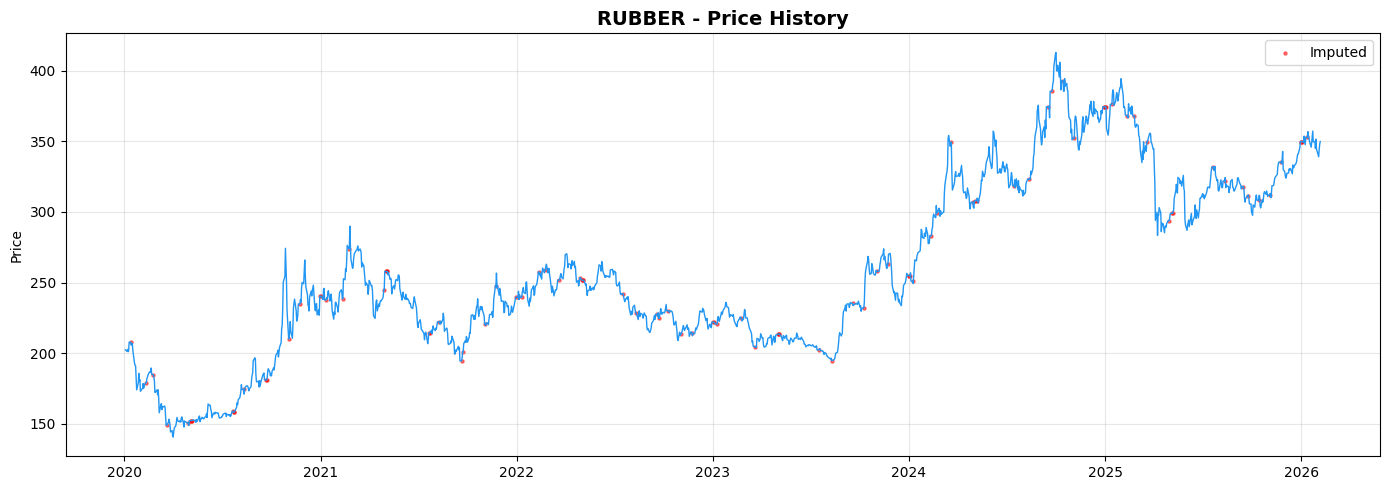

In [59]:
# Plot price history
fig, ax = plt.subplots(figsize=(14, 5))
ax.plot(df_clean['date'], df_clean['close'], color='#2196F3', linewidth=1)
if 'is_imputed' in df_clean.columns:
    imp = df_clean[df_clean['is_imputed'] == True]
    if len(imp) > 0:
        ax.scatter(imp['date'], imp['close'], color='red', s=5, alpha=0.5, label='Imputed')
        ax.legend()
ax.set_title(f'{COMMODITY_ID.upper()} - Price History', fontsize=14, fontweight='bold')
ax.set_ylabel('Price'); ax.grid(True, alpha=0.3)
plt.tight_layout(); plt.show()

## 3. Feature Engineering

In [60]:
from src.features.generator import FeatureGenerator

fg = FeatureGenerator(
    lag_days=[1, 2, 3, 5, 7, 14, 21, 30],
    rolling_windows=[7, 14, 30, 60],
    rolling_stats=['mean', 'std', 'min', 'max'],
    calendar_features=True,
    volatility_features=True,
)

df_features = fg.generate(df_transformed)
feature_names = fg.get_feature_names()
print(f'Generated {len(feature_names)} features, shape: {df_features.shape}')

# Show sample
sample_cols = ['date', 'close', 'lag_1', 'lag_7', 'rolling_mean_7', 'volatility_7', 'return_1d', 'month']
df_features[[c for c in sample_cols if c in df_features.columns]].tail(5)

Generated 52 features, shape: (1590, 62)


,date,close,lag_1,lag_7,rolling_mean_7,volatility_7,return_1d,month
1585,2026-01-30,343.3,344.5,353.1,350.142857,0.016840,-0.003483,1
1586,2026-02-02,339.1,343.3,357.3,348.742857,0.015715,-0.012234,2
1587,2026-02-03,344.2,339.1,349.6,346.142857,0.014249,0.015040,2
1588,2026-02-04,348.1,344.2,349.9,345.371429,0.014871,0.011331,2
1589,2026-02-05,349.9,348.1,345.0,345.114286,0.015724,0.005171,2


## 4. Train/Test Split

In [61]:
from src.preprocessing.splitter import TimeSeriesSplitter

ml_feature_cols = [c for c in feature_names if c in df_features.columns]
df_ml = df_features.dropna(subset=ml_feature_cols + ['close']).copy()
print(f'Rows after dropping NaN: {len(df_ml)}')

splitter = TimeSeriesSplitter(train_ratio=0.8, min_test_days=30)
split = splitter.split(df_ml)
train_df, test_df = split.train_df, split.test_df
print(split.summary())

X_train, y_train = train_df[ml_feature_cols], train_df['close']
X_test,  y_test  = test_df[ml_feature_cols],  test_df['close']

# Validation set for early stopping
val_size = int(len(X_train) * 0.1)
X_tr, X_val = X_train.iloc[:-val_size], X_train.iloc[-val_size:]
y_tr, y_val = y_train.iloc[:-val_size], y_train.iloc[-val_size:]

print(f'\nX_train: {X_train.shape}, X_val: {X_val.shape}, X_test: {X_test.shape}')

2026-02-10 11:41:52.181 | INFO     | src.preprocessing.splitter:split:109 - Split: train=1248 rows, test=312 rows, gap=0, split_date=2024-11-26 00:00:00


Rows after dropping NaN: 1560
Train: 2020-02-14 00:00:00 -> 2024-11-26 00:00:00 (1248 rows)
Test:  2024-11-27 00:00:00 -> 2026-02-05 00:00:00 (312 rows)
Gap:   0 days

X_train: (1248, 52), X_val: (124, 52), X_test: (312, 52)


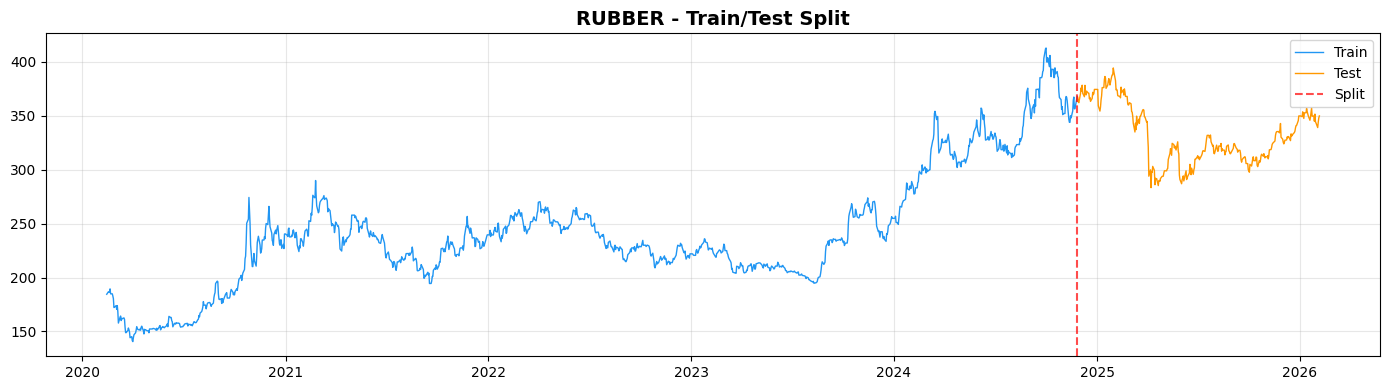

In [62]:
# Visualize split
fig, ax = plt.subplots(figsize=(14, 4))
ax.plot(train_df['date'], y_train, color='#2196F3', label='Train', linewidth=1)
ax.plot(test_df['date'], y_test, color='#FF9800', label='Test', linewidth=1)
ax.axvline(x=train_df['date'].iloc[-1], color='red', linestyle='--', alpha=0.7, label='Split')
ax.set_title(f'{COMMODITY_ID.upper()} - Train/Test Split', fontsize=14, fontweight='bold')
ax.legend(); ax.grid(True, alpha=0.3)
plt.tight_layout(); plt.show()

## 5. Model Training

### 5.1 Baseline Models

In [63]:
from src.models.baseline import NaiveModel, SeasonalNaiveModel, DriftModel, MeanModel
from src.evaluation.metrics import calculate_metrics

baselines = {
    'Naive': NaiveModel(),
    'Seasonal Naive (7d)': SeasonalNaiveModel(season_length=7),
    'Drift': DriftModel(),
    'Mean (30d)': MeanModel(window=30),
}

baseline_results = {}
baseline_preds = {}
for name, model in baselines.items():
    model.fit(y_train)
    preds = model.predict(len(y_test))
    metrics = calculate_metrics(y_test.values, preds, y_train.values)
    baseline_results[name] = metrics
    baseline_preds[name] = preds
    print(f'{name:25s} | MAE={metrics["mae"]:8.2f} | MAPE={metrics["mape"]:5.2f}%')

Naive                     | MAE=   38.27 | MAPE=12.15%
Seasonal Naive (7d)       | MAE=   34.57 | MAPE=10.95%
Drift                     | MAE=   60.03 | MAPE=18.91%
Mean (30d)                | MAE=   36.09 | MAPE=11.45%


### 5.2 ML Models (XGBoost, LightGBM, RandomForest)

In [64]:
from src.models.ml import XGBoostForecaster, LightGBMForecaster, RandomForestForecaster

ml_models = {}
ml_results = {}
ml_preds = {}

# --- XGBoost ---
try:
    xgb = XGBoostForecaster(n_estimators=500, max_depth=6, learning_rate=0.05)
    xgb.fit(y_tr, X_tr, X_val=X_val, y_val=y_val)
    p = xgb.predict(X=X_test)
    ml_models['XGBoost'] = xgb
    ml_results['XGBoost'] = calculate_metrics(y_test.values, p, y_train.values)
    ml_preds['XGBoost'] = p
    print(f"XGBoost:      MAE={ml_results['XGBoost']['mae']:.2f}  MAPE={ml_results['XGBoost']['mape']:.2f}%")
except Exception as e:
    print(f'XGBoost failed: {e}')

# --- LightGBM ---
try:
    lgb = LightGBMForecaster(n_estimators=500, max_depth=6, learning_rate=0.05)
    lgb.fit(y_tr, X_tr, X_val=X_val, y_val=y_val)
    p = lgb.predict(X=X_test)
    ml_models['LightGBM'] = lgb
    ml_results['LightGBM'] = calculate_metrics(y_test.values, p, y_train.values)
    ml_preds['LightGBM'] = p
    print(f"LightGBM:     MAE={ml_results['LightGBM']['mae']:.2f}  MAPE={ml_results['LightGBM']['mape']:.2f}%")
except Exception as e:
    print(f'LightGBM failed: {e}')

# --- RandomForest ---
try:
    rf = RandomForestForecaster(n_estimators=200, max_depth=10)
    rf.fit(y_train, X_train)
    p = rf.predict(X=X_test)
    ml_models['RandomForest'] = rf
    ml_results['RandomForest'] = calculate_metrics(y_test.values, p, y_train.values)
    ml_preds['RandomForest'] = p
    print(f"RandomForest: MAE={ml_results['RandomForest']['mae']:.2f}  MAPE={ml_results['RandomForest']['mape']:.2f}%")
except Exception as e:
    print(f'RandomForest failed: {e}')

2026-02-10 11:42:12.553 | INFO     | src.models.ml:fit:150 - XGBoost fitted with 52 features


XGBoost:      MAE=15.16  MAPE=4.24%


2026-02-10 11:42:12.838 | INFO     | src.models.ml:fit:264 - LightGBM fitted with 52 features


LightGBM:     MAE=13.35  MAPE=3.76%


2026-02-10 11:42:13.528 | INFO     | src.models.ml:fit:341 - RandomForest fitted with 52 features


RandomForest: MAE=3.68  MAPE=1.15%


### 5.3 Advanced Models (CatBoost, ElasticNet, SVR)

In [66]:
%pip install catboost

  Using cached plotly-6.5.2-py3-none-any.whl.metadata (8.5 kB)
  Using cached narwhals-2.16.0-py3-none-any.whl.metadata (14 kB)
   ---------------------------------------- 0.0/102.4 MB ? eta -:--:--
   ---------------------------------------- 0.0/102.4 MB ? eta -:--:--
   ---------------------------------------- 0.0/102.4 MB ? eta -:--:--
   ---------------------------------------- 0.3/102.4 MB ? eta -:--:--
   ---------------------------------------- 0.3/102.4 MB ? eta -:--:--
   ---------------------------------------- 0.3/102.4 MB ? eta -:--:--
   ---------------------------------------- 0.5/102.4 MB 357.1 kB/s eta 0:04:46
   ---------------------------------------- 0.5/102.4 MB 357.1 kB/s eta 0:04:46
   ---------------------------------------- 0.8/102.4 MB 430.1 kB/s eta 0:03:57
   ---------------------------------------- 0.8/102.4 MB 430.1 kB/s eta 0:03:57
   ---------------------------------------- 0.8/102.4 MB 430.1 kB/s eta 0:03:57
   ---------------------------------------- 1.

In [67]:
from src.models.ml_advanced import CatBoostForecaster, ElasticNetForecaster, SVRForecaster

# --- CatBoost ---
try:
    cb = CatBoostForecaster(iterations=500, depth=6, learning_rate=0.05)
    cb.fit(y_tr, X_tr, X_val=X_val, y_val=y_val)
    p = cb.predict(X=X_test)
    ml_models['CatBoost'] = cb
    ml_results['CatBoost'] = calculate_metrics(y_test.values, p, y_train.values)
    ml_preds['CatBoost'] = p
    print(f"CatBoost:     MAE={ml_results['CatBoost']['mae']:.2f}  MAPE={ml_results['CatBoost']['mape']:.2f}%")
except ImportError:
    print('CatBoost not installed. Run: pip install catboost')
except Exception as e:
    print(f'CatBoost failed: {e}')

# --- ElasticNet ---
try:
    en = ElasticNetForecaster(alpha=1.0, l1_ratio=0.5)
    en.fit(y_train, X_train)
    p = en.predict(X=X_test)
    ml_models['ElasticNet'] = en
    ml_results['ElasticNet'] = calculate_metrics(y_test.values, p, y_train.values)
    ml_preds['ElasticNet'] = p
    print(f"ElasticNet:   MAE={ml_results['ElasticNet']['mae']:.2f}  MAPE={ml_results['ElasticNet']['mape']:.2f}%")
except Exception as e:
    print(f'ElasticNet failed: {e}')

# --- SVR ---
try:
    svr = SVRForecaster(C=100.0, epsilon=0.1)
    svr.fit(y_train, X_train)
    p = svr.predict(X=X_test)
    ml_models['SVR'] = svr
    ml_results['SVR'] = calculate_metrics(y_test.values, p, y_train.values)
    ml_preds['SVR'] = p
    print(f"SVR:          MAE={ml_results['SVR']['mae']:.2f}  MAPE={ml_results['SVR']['mape']:.2f}%")
except Exception as e:
    print(f'SVR failed: {e}')

2026-02-10 11:45:23.779 | INFO     | src.models.ml_advanced:fit:86 - CatBoost fitted with 52 features
2026-02-10 11:45:23.791 | INFO     | src.models.ml_advanced:fit:174 - ElasticNet fitted with 52 features


CatBoost:     MAE=17.87  MAPE=5.10%
ElasticNet:   MAE=4.72  MAPE=1.45%


2026-02-10 11:45:24.151 | INFO     | src.models.ml_advanced:fit:264 - SVR fitted with 52 features


SVR:          MAE=14.37  MAPE=4.09%


## 6. Model Comparison

In [68]:
all_results = {**baseline_results, **ml_results}
results_df = pd.DataFrame(all_results).T.sort_values('mae')

print('=== Model Comparison (sorted by MAE) ===')
results_df[['mae', 'rmse', 'mape', 'smape', 'mase']].round(4)

=== Model Comparison (sorted by MAE) ===


,mae,rmse,mape,smape,mase
RandomForest,3.6772,5.3230,1.1457,1.1353,1.2474
ElasticNet,4.7204,6.4972,1.4503,1.4417,1.6013
LightGBM,13.3522,20.1466,3.7556,3.8941,4.5294
SVR,14.3686,21.3852,4.0936,4.2775,4.8742
XGBoost,15.1595,23.3135,4.2440,4.4376,5.1425
CatBoost,17.8714,24.1524,5.0992,5.2996,6.0625
Seasonal Naive (7d),34.5702,40.5151,10.9452,10.1854,11.7272
Mean (30d),36.0897,42.2779,11.4500,10.6075,12.2426
Naive,38.2667,44.8960,12.1528,11.1982,12.9811
Drift,60.0336,68.2085,18.9122,16.8257,20.3650


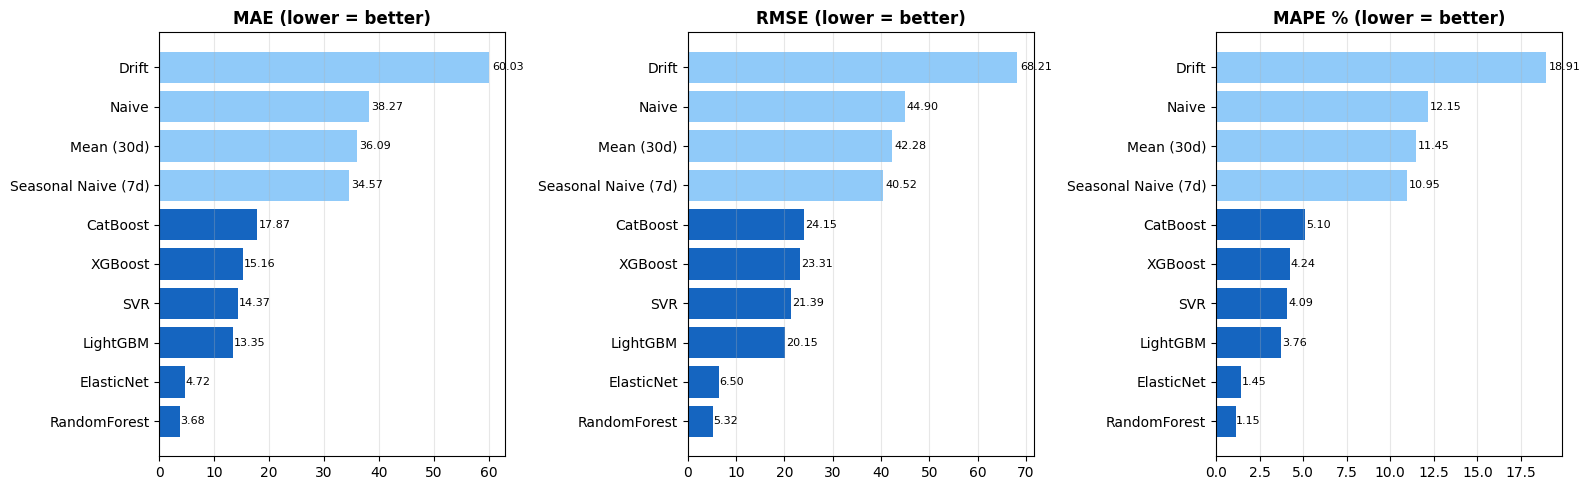

In [69]:
# Bar chart
fig, axes = plt.subplots(1, 3, figsize=(16, 5))
for ax, metric, title in zip(axes, ['mae','rmse','mape'],
                              ['MAE','RMSE','MAPE %']):
    colors = ['#1565C0' if m in ml_results else '#90CAF9' for m in results_df.index]
    bars = ax.barh(results_df.index, results_df[metric], color=colors)
    ax.set_title(f'{title} (lower = better)', fontsize=12, fontweight='bold')
    ax.grid(True, alpha=0.3, axis='x')
    for bar, val in zip(bars, results_df[metric]):
        ax.text(bar.get_width()*1.01, bar.get_y()+bar.get_height()/2, f'{val:.2f}', va='center', fontsize=8)
plt.tight_layout(); plt.show()

## 7. Predictions vs Actuals

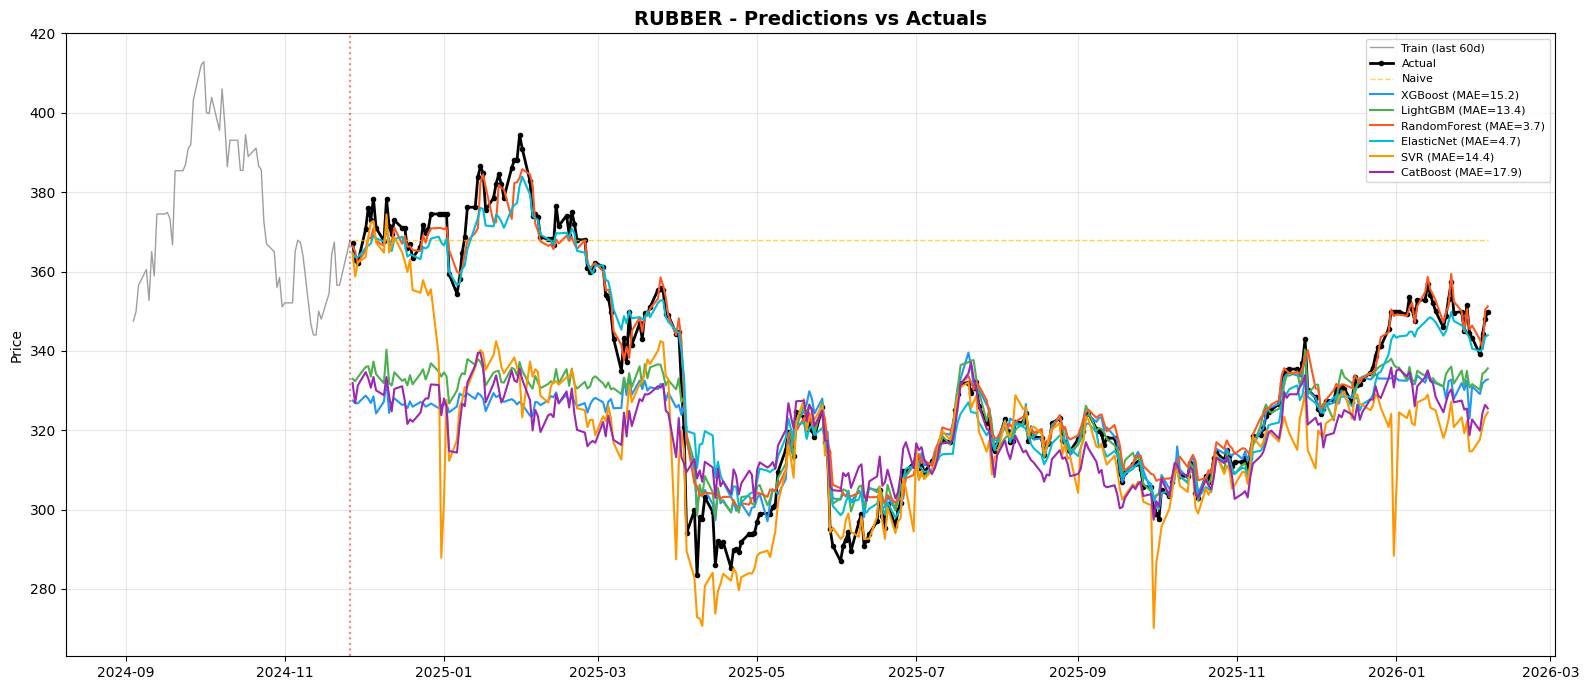

In [70]:
fig, ax = plt.subplots(figsize=(16, 7))

test_dates = test_df['date'].values
train_tail = train_df.tail(60)
ax.plot(train_tail['date'], train_tail['close'], color='#9E9E9E', linewidth=1, label='Train (last 60d)')
ax.plot(test_dates, y_test.values, color='black', linewidth=2, label='Actual', marker='o', markersize=3)

# Baseline
ax.plot(test_dates, baseline_preds['Naive'], color='#FFC107', linewidth=1, linestyle='--', alpha=0.7, label='Naive')

# ML models with colors
ml_colors = {'XGBoost':'#2196F3', 'LightGBM':'#4CAF50', 'RandomForest':'#FF5722',
             'CatBoost':'#9C27B0', 'ElasticNet':'#00BCD4', 'SVR':'#FF9800'}
for name, preds in ml_preds.items():
    mae = ml_results[name]['mae']
    ax.plot(test_dates, preds, color=ml_colors.get(name,'gray'), linewidth=1.5,
            label=f'{name} (MAE={mae:.1f})')

ax.axvline(x=train_df['date'].iloc[-1], color='red', linestyle=':', alpha=0.5)
ax.set_title(f'{COMMODITY_ID.upper()} - Predictions vs Actuals', fontsize=14, fontweight='bold')
ax.set_ylabel('Price'); ax.legend(loc='best', fontsize=8); ax.grid(True, alpha=0.3)
plt.tight_layout(); plt.show()

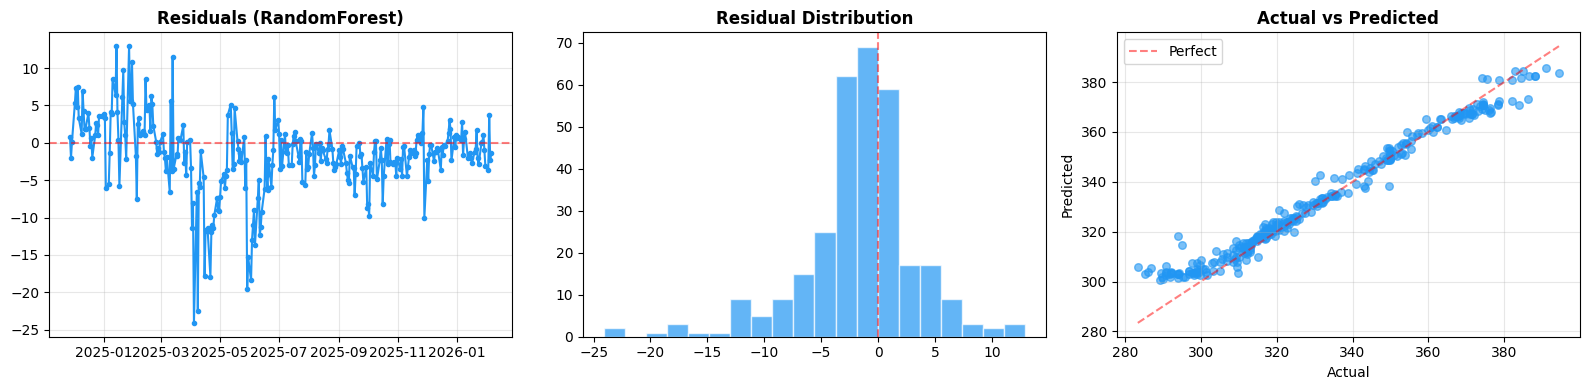

In [71]:
# Residual analysis for best model
best_name = results_df.index[0]
best_p = ml_preds.get(best_name, baseline_preds.get(best_name))
residuals = y_test.values - best_p

fig, axes = plt.subplots(1, 3, figsize=(16, 4))
axes[0].plot(test_dates, residuals, 'o-', markersize=3, color='#2196F3')
axes[0].axhline(0, color='red', ls='--', alpha=0.5)
axes[0].set_title(f'Residuals ({best_name})', fontweight='bold'); axes[0].grid(True, alpha=0.3)

axes[1].hist(residuals, bins=20, color='#2196F3', edgecolor='white', alpha=0.7)
axes[1].axvline(0, color='red', ls='--', alpha=0.5)
axes[1].set_title('Residual Distribution', fontweight='bold')

axes[2].scatter(y_test.values, best_p, color='#2196F3', alpha=0.6, s=30)
lim = [min(y_test.min(), best_p.min()), max(y_test.max(), best_p.max())]
axes[2].plot(lim, lim, 'r--', alpha=0.5, label='Perfect')
axes[2].set_title('Actual vs Predicted', fontweight='bold')
axes[2].set_xlabel('Actual'); axes[2].set_ylabel('Predicted'); axes[2].legend(); axes[2].grid(True, alpha=0.3)
plt.tight_layout(); plt.show()

## 8. Feature Importance

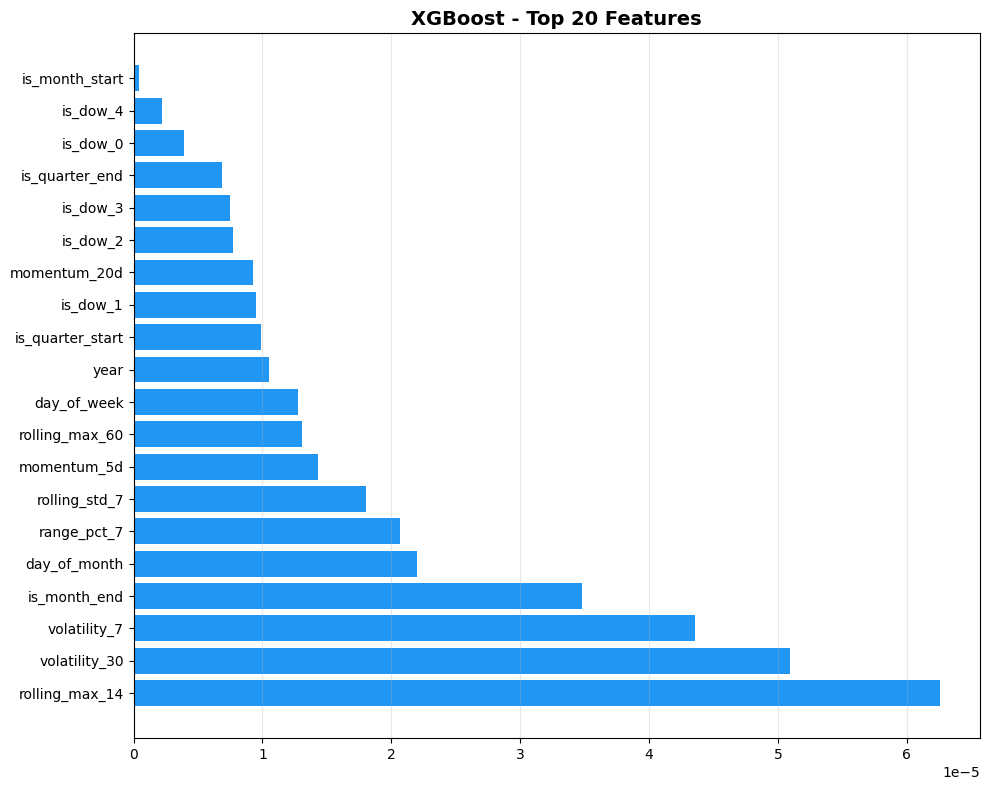

In [72]:
# Feature importance from best tree-based model
tree_models = {k: v for k, v in ml_models.items() if k in ['XGBoost','LightGBM','CatBoost','RandomForest']}
if tree_models:
    best_tree = list(tree_models.values())[0]
    imp = best_tree.get_feature_importance()
    if imp is not None and len(imp) > 0:
        top20 = imp.tail(20) if 'importance' in imp.columns else imp.nlargest(20, imp.columns[-1])
        fig, ax = plt.subplots(figsize=(10, 8))
        ax.barh(top20['feature'], top20['importance'], color='#2196F3')
        ax.set_title(f'{list(tree_models.keys())[0]} - Top 20 Features', fontsize=14, fontweight='bold')
        ax.grid(True, alpha=0.3, axis='x')
        plt.tight_layout(); plt.show()

## 9. Future Price Forecast

Predict the next N days into the future starting from the latest available data point.

In [76]:
print(type(best_ml_name))

<class 'str'>


In [89]:
from src.inference.future_forecaster import FutureForecaster

# Use the best ML model for forecasting
best_ml_name = min(ml_results, key=lambda k: ml_results[k]['mae'])
best_model = ml_models[best_ml_name]
print(f'Using best model: {best_ml_name} (MAE={ml_results[best_ml_name]["mae"]:.2f})')

# Calculate residual std from test set for confidence intervals
best_test_preds = ml_preds[best_ml_name]
residual_std = np.std(y_test.values - best_test_preds)
print(f'Residual std: {residual_std:.2f}')

# Forecast 30 days ahead
N_DAYS = 14

forecaster = FutureForecaster(
    loader=loader, cleaner=cleaner,
    feature_generator=fg, transformer=transformer,
)

forecast_df = forecaster.forecast(
    model=best_model,
    commodity_id=COMMODITY_ID,
    n_days=N_DAYS,
    feature_cols=ml_feature_cols,
    residual_std=residual_std,
)

print(f'\nForecast for next {N_DAYS} days:')
forecast_df

2026-02-10 12:26:56.040 | INFO     | src.ingestion.loader:load_commodity:80 - Loaded 1489 records for rubber
2026-02-10 12:26:56.045 | INFO     | src.preprocessing.cleaner:_detect_frequency:114 - Auto-detected business frequency (0.0% weekend dates)
2026-02-10 12:26:56.103 | INFO     | src.inference.future_forecaster:forecast:112 - Starting 14-day forecast for rubber from 2026-02-05 (last price: 349.90)


Using best model: RandomForest (MAE=3.68)
Residual std: 5.05


2026-02-10 12:26:56.674 | INFO     | src.inference.future_forecaster:forecast:175 - Forecast complete: 14 days, last predicted price: 356.77 (+1.96%)



Forecast for next 14 days:


,date,predicted_price,ci_lower,ci_upper,day_ahead
0,2026-02-06,351.211324,341.311737,361.110911,1
1,2026-02-09,351.814799,337.814669,365.814928,2
2,2026-02-10,352.312181,335.165594,369.458769,3
3,2026-02-11,351.963244,332.164070,371.762417,4
4,2026-02-12,353.956151,331.820003,376.092300,5
5,2026-02-13,353.876357,329.627421,378.125293,6
6,2026-02-16,355.308648,329.116804,381.500493,7
7,2026-02-17,356.954669,328.954409,384.954928,8
8,2026-02-18,357.511051,327.812291,387.209811,9
9,2026-02-19,357.728969,326.423727,389.034211,10


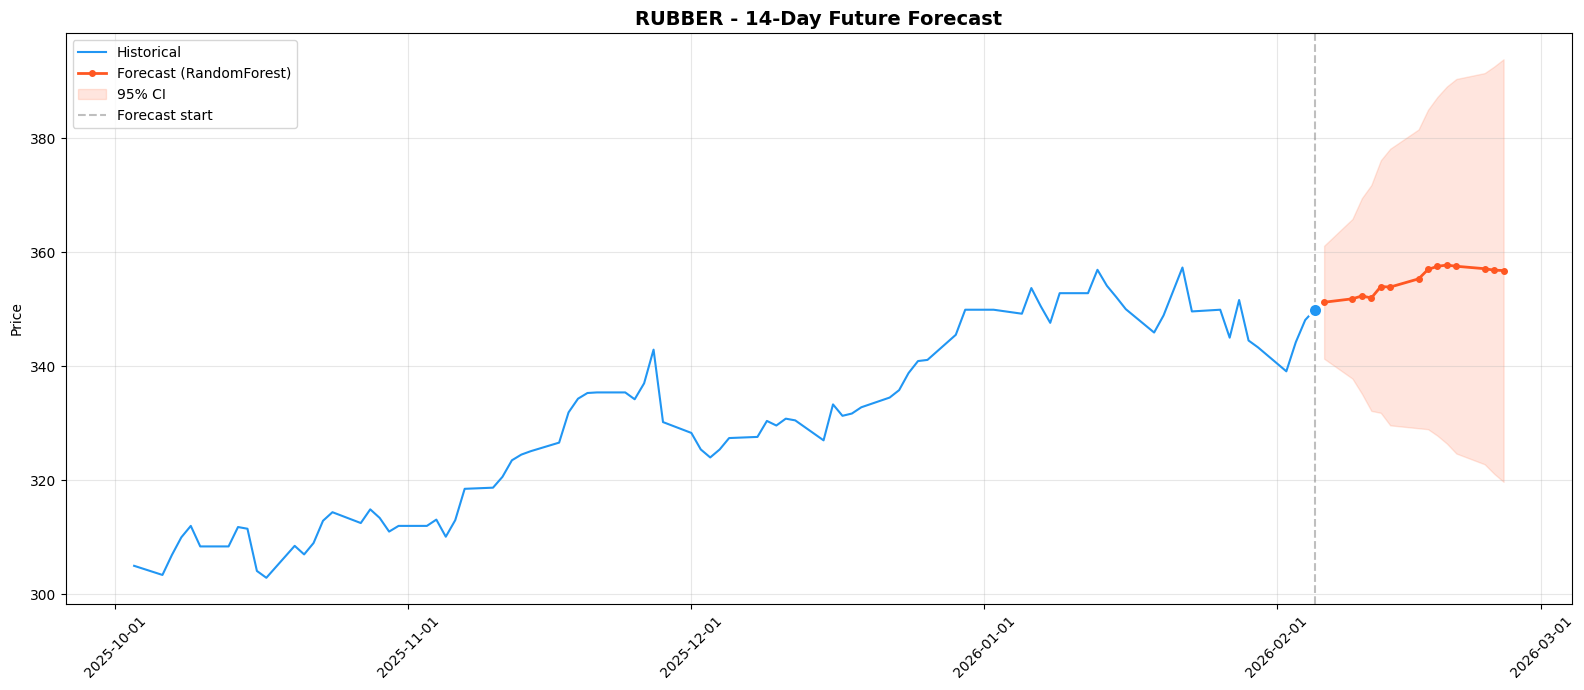


Last known price: 349.90
Day 1 forecast:   351.21
Day 14 forecast:  356.77
Change:           +1.96%


In [90]:
# Visualize future forecast
fig, ax = plt.subplots(figsize=(16, 7))

# Historical data (last 90 days)
hist_df = df_ml.tail(90)
ax.plot(hist_df['date'], hist_df['close'], color='#2196F3', linewidth=1.5, label='Historical')

# Last known price
last_date = hist_df['date'].iloc[-1]
last_price = hist_df['close'].iloc[-1]
ax.scatter([last_date], [last_price], color='#2196F3', s=100, zorder=5, edgecolors='white', linewidth=2)

# Forecast
fc_dates = pd.to_datetime(forecast_df['date'])
ax.plot(fc_dates, forecast_df['predicted_price'], color='#FF5722', linewidth=2,
        marker='o', markersize=4, label=f'Forecast ({best_ml_name})')

# Confidence interval
ax.fill_between(fc_dates, forecast_df['ci_lower'], forecast_df['ci_upper'],
                color='#FF5722', alpha=0.15, label='95% CI')

# Styling
ax.axvline(x=last_date, color='gray', linestyle='--', alpha=0.5, label='Forecast start')
ax.set_title(f'{COMMODITY_ID.upper()} - {N_DAYS}-Day Future Forecast', fontsize=14, fontweight='bold')
ax.set_ylabel('Price')
ax.legend(loc='best')
ax.grid(True, alpha=0.3)
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
plt.setp(ax.xaxis.get_majorticklabels(), rotation=45)
plt.tight_layout(); plt.show()

# Summary stats
print(f'\nLast known price: {last_price:.2f}')
print(f'Day 1 forecast:   {forecast_df["predicted_price"].iloc[0]:.2f}')
print(f'Day {N_DAYS} forecast:  {forecast_df["predicted_price"].iloc[-1]:.2f}')
pct = (forecast_df['predicted_price'].iloc[-1] / last_price - 1) * 100
print(f'Change:           {pct:+.2f}%')

## 10. Batch Train All Commodities

In [ ]:
batch_results = []

for c in commodities:
    cid = c['id']
    try:
        df = loader.load_commodity(cid)
        df = cleaner.clean(df)
        df = transformer.transform(df)
        df = fg.generate(df)
        feat_cols = [f for f in fg.get_feature_names() if f in df.columns]
        df = df.dropna(subset=feat_cols + ['close'])
        
        if len(df) < 60:
            batch_results.append({'commodity': cid, 'error': f'Only {len(df)} rows'})
            continue
        
        result = splitter.split(df)
        X_tr_b, y_tr_b = result.train_df[feat_cols], result.train_df['close']
        X_te_b, y_te_b = result.test_df[feat_cols], result.test_df['close']
        
        model = XGBoostForecaster(n_estimators=300, max_depth=6, learning_rate=0.05)
        model.fit(y_tr_b, X_tr_b)
        preds = model.predict(X=X_te_b)
        m = calculate_metrics(y_te_b.values, preds, y_tr_b.values)
        
        batch_results.append({
            'commodity': cid, 'train': len(X_tr_b), 'test': len(X_te_b),
            'mae': m['mae'], 'rmse': m['rmse'], 'mape': m['mape'], 'mase': m.get('mase'),
        })
        print(f'{cid:12s}: MAE={m["mae"]:10.2f}  MAPE={m["mape"]:6.2f}%')
    except Exception as e:
        batch_results.append({'commodity': cid, 'error': str(e)})
        print(f'{cid:12s}: ERROR - {e}')

batch_df = pd.DataFrame(batch_results)
print(f'\nTrained: {batch_df["mae"].notna().sum()}/{len(commodities)}')

In [ ]:
# Batch results chart
valid = batch_df.dropna(subset=['mape']).sort_values('mape')
fig, ax = plt.subplots(figsize=(10, 6))
colors = ['#4CAF50' if v < 5 else '#FFC107' if v < 10 else '#FF5722' for v in valid['mape']]
ax.barh(valid['commodity'], valid['mape'], color=colors)
ax.set_title('MAPE by Commodity (%)', fontsize=14, fontweight='bold')
ax.set_xlabel('MAPE %'); ax.grid(True, alpha=0.3, axis='x')
for i, (_, row) in enumerate(valid.iterrows()):
    ax.text(row['mape']+0.1, i, f'{row["mape"]:.1f}%', va='center', fontsize=9)
plt.tight_layout(); plt.show()

## 11. Save Model & Predictions

In [ ]:
# Save best model
model_dir = os.path.join(PROJECT_ROOT, 'models', COMMODITY_ID)
os.makedirs(model_dir, exist_ok=True)

save_path = os.path.join(model_dir, f'{best_ml_name.lower()}_best.model')
best_model.save(save_path)
print(f'Best model ({best_ml_name}) saved to: {save_path}')

# Save predictions
pred_path = os.path.join(PROJECT_ROOT, 'data', 'predictions', f'{COMMODITY_ID}_predictions.csv')
os.makedirs(os.path.dirname(pred_path), exist_ok=True)

pred_df = pd.DataFrame({
    'date': test_df['date'].values,
    'actual': y_test.values,
    **{name: preds for name, preds in ml_preds.items()},
})
pred_df.to_csv(pred_path, index=False)
print(f'Predictions saved to: {pred_path}')

# Save future forecast
fc_path = os.path.join(PROJECT_ROOT, 'data', 'predictions', f'{COMMODITY_ID}_forecast_{N_DAYS}d.csv')
forecast_df.to_csv(fc_path, index=False)
print(f'Future forecast saved to: {fc_path}')

---
**Done!** Change `COMMODITY_ID` in Section 1 and re-run all cells for a different commodity.